# PlayerUnknown's Battlegrounds (PUBG) Finish Placement Prediction

[![link](https://i.imgur.com/BBayZj9.jpg)](https://www.kaggle.com/competitions/pubg-finish-placement-prediction)

Click on picture for more information

* In this project, we are going to create an accurate machine learning model that can predict the ranking position of players in a PUBG compeition. Players can be on solo or in teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In a game, players have access to different accesories and player moves which were recorded as game stats during a competition.
* We are provided with a large number of anonymized PUBG game stats from over 65,000 PUBG games, formatted so that each row contains one player's post-game stats. The data comes in a zip file containing 3 csv files train, test and sample submission. Since the possible placements are between 0 and 1 we will use CatBoostRegressor and LGBMRegressor model plus GridSearchCV to tune our regressors to get the best performing models.



## Downloading and Loading the Data

### Importing libraries

In [ ]:
#Let's install and import some required libraries before we begin.
!pip install pandas-profiling numpy matplotlib seaborn pyarrow featuretools --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.7/555.7 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 30.3 MB/s eta 0:00:00


In [ ]:
!pip install opendatasets scikit-learn jovian kaggle --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing analysis libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import gc
import featuretools as ft

plt.rcParams["figure.figsize"] = (10, 8)

In [ ]:
# Importing preprocessing libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# Importing Machine Learning Libraries
!pip install catboost --quiet

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

### Downloading data and Creating the DataFrame

In [ ]:
#configuring the environment from which the file with the kaggle API is
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [ ]:
!kaggle competitions download -c pubg-finish-placement-prediction

 99% 358M/361M [00:12<00:00, 30.9MB/s]
100% 361M/361M [00:12<00:00, 29.7MB/s]


In [ ]:
#extrating the data files from the zip file
!unzip pubg-finish-placement-prediction.zip -d data

Archive:  pubg-finish-placement-prediction.zip
  inflating: data/sample_submission_V2.csv  
  inflating: data/test_V2.csv        
  inflating: data/train_V2.csv       


In [ ]:
#loading the data as datframes
raw_df = pd.read_csv('data/train_V2.csv')
test_df = pd.read_csv('data/test_V2.csv')
sample_df = pd.read_csv('data/sample_submission_V2.csv')

In [ ]:
raw_df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


In [ ]:
test_df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.000,0,0,588.00,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.000,0,0,2017.00,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.000,0,0,787.80,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.000,0,0,1812.00,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.000,0,0,2963.00,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.00,3,0,7,4,...,-1,1,0.0,0,0.000,0,0,1799.00,5,1526
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.00,0,0,0,64,...,-1,0,0.0,0,0.000,0,0,1195.00,3,1496
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.96,0,0,3,24,...,1482,0,0.0,0,7.798,1,0,3327.00,3,0
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.60,0,0,12,25,...,1456,1,0.0,0,0.000,0,0,1893.00,4,0


Okay, so looking at the head of the data. We can see a few rows to get rid of since they are not useful for our purposes here. I think ID, GroupID, and Match ID are irrelevant to our predictions as they are essentially just labels. Additionally, there is the Match_Type, which at a base level may be meaningless. But we could actually cut up this data to make multiple models for the multiple game-modes. For the sake of a first look implementation and competition requirements. Let's not for now.

Additionally there's quite a few anomalous values for rank points, with -1 values amongst 1500's or greater. This just seems not great so we'll have to do something about it.

In [ ]:
sample_df

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1
...,...,...
1934169,a316c3a13887d5,1
1934170,5312146b27d875,1
1934171,fc8818b5b32ad3,1
1934172,a0f91e35f8458f,1


In [ ]:
raw_df.shape

(4446966, 29)

In [ ]:
test_df.shape

(1934174, 28)

In [ ]:
#looking at the structure of our database
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
#looking at a summary of our database
raw_df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [ ]:
#looking at the structure of our database
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
#looking at a summary of our database
test_df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
count,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,...,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06
mean,2.299524e-01,1.104360e+00,1.297406e+02,6.541500e-01,2.258147e-01,1.357999e+00,4.781403e+01,5.094502e+02,9.183569e-01,5.435855e-01,...,8.873689e+02,1.630189e-01,5.909889e+02,3.408690e-03,4.505277e+00,2.335829e-02,7.680798e-03,1.149258e+03,3.627590e+00,6.113582e+02
std,5.785920e-01,1.713828e+00,1.674371e+02,1.133690e+00,5.933918e-01,2.665694e+00,2.746275e+01,6.288322e+02,1.523761e+00,7.090114e-01,...,7.378231e+02,4.682340e-01,1.474899e+03,7.298342e-02,3.026267e+01,1.650875e-01,9.149580e-02,1.179668e+03,2.359042e+00,7.406629e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.541000e+02,2.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.416000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,1.442000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.795000e+02,3.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00,1.854000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.175000e+03,1.000000e+00,1.000000e+00,...,1.500000e+03,0.000000e+00,6.300000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+03,5.000000e+00,1.495000e+03
max,2.700000e+01,2.400000e+01,6.229000e+03,5.900000e+01,4.100000e+01,7.500000e+01,1.000000e+02,2.174000e+03,5.800000e+01,1.500000e+01,...,5.742000e+03,2.000000e+01,4.070000e+04,1.500000e+01,3.271000e+03,9.000000e+00,5.000000e+00,1.491000e+04,1.530000e+02,2.000000e+03


### Memory management

Reducing Dataset Memory
* Here we are reducing the memory of the dataset by downcasting the datatypes of the column as small as possible so that there will be less time consumption for applying computational operations on it

In [ ]:
raw1_df = raw_df.copy()
test1_df = test_df.copy()

In [ ]:
#creating a function to compress on databases
def reduce_mem_usage(df):
  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()

      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)

  return df

In [ ]:
raw1_df = reduce_mem_usage(raw_df.copy())

In [ ]:
raw1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [ ]:
test1_df = reduce_mem_usage(test_df.copy())

In [ ]:
test1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

The original memory usage for the raw_df and test_df were 983.9+ MB, memory usage: 413.2+ MB respectively but is now 339.3+ MB, memory usage: 140.2+ MB respectively. An average of 66% reduction in memmory usage.

Number of NULL value in Data

In [ ]:
raw1_df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

Here we can see there is only one null value for winPlacePerc feature, most probably it was a disqualified match, hence we can drop that row as 1 row in compare to the size of the dataset won't affect the output.

In [ ]:
raw1_df.dropna(inplace=True)

## Exploratory Data Analysis

### Relationship with winPlacePerc

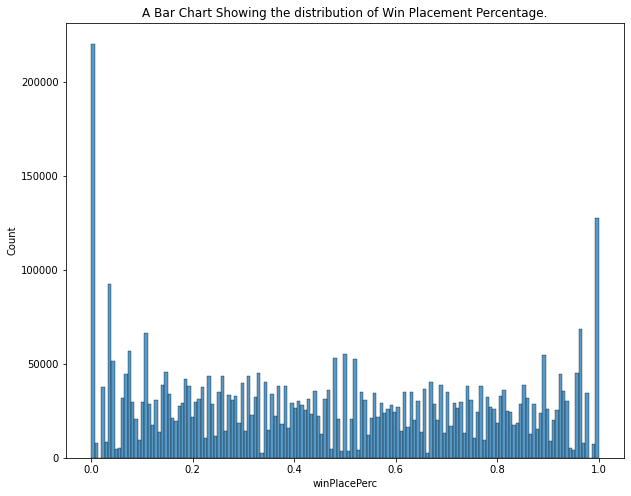

In [ ]:
#Plot win placement percentage
sns.histplot(data=raw1_df, x="winPlacePerc").set(title="A Bar Chart Showing the distribution of Win Placement Percentage.");

The bins in the graph show the count of the values in the winPlacePerc column. From this we can see that 1 and 0 are the most common placements in our dataset.

#### Player Types



In [ ]:
labelencoder = LabelEncoder()

In [ ]:
## So from the above there are many matchtypes with combination of fpp, tpp , solo, duo ,squad,etc.
## So we are generalizing them into only solo, duo and squad.
## After that applying LabelEncoding to matchType column

raw1_df['matchType'] = raw1_df['matchType'].apply(lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad')

raw1_df['matchType'] = labelencoder.fit_transform(raw1_df['matchType'])
raw1_df['matchType'].value_counts()

2    2403625
0    1322628
1     720712
Name: matchType, dtype: int64

In [ ]:
players = raw1_df['matchType'].value_counts()
print("Squad Players  : ",players[2])
print("Duo Players  : ",players[0])
print("Solo Players  : ",players[1])
print("Total Players : ",players[0]+players[1]+players[2])

Squad Players  :  2403625
Duo Players  :  1322628
Solo Players  :  720712
Total Players :  4446965


In [ ]:
test1_df['matchType'] = test1_df['matchType'].apply(lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad')

test1_df['matchType'] = labelencoder.fit_transform(test1_df['matchType'])
test1_df['matchType'].value_counts()

2    1033085
0     587165
1     313924
Name: matchType, dtype: int64

#### The killers

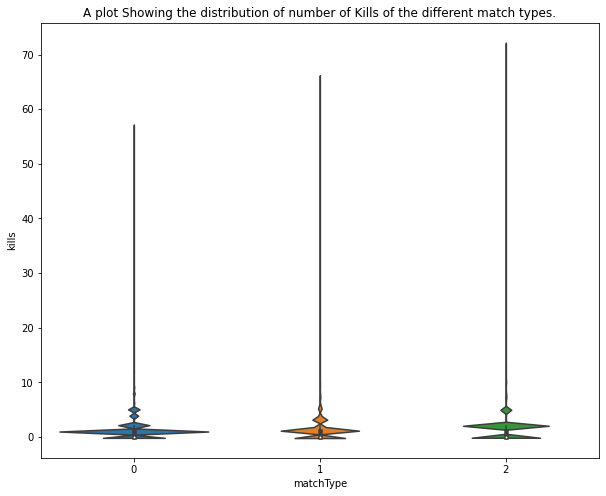

In [ ]:
sns.violinplot(data= raw1_df, x="matchType", y="kills").set(title="A plot Showing the distribution of number of Kills of the different match types.");

From the graph we can see that kill counts below 10 are more common than above 10. Also, the duo team play (0) has most kills below 5 which squad team play has the highest recorded number of kills. Surprisingly solo team play's (1) highest kills is higher than that for duo team play.

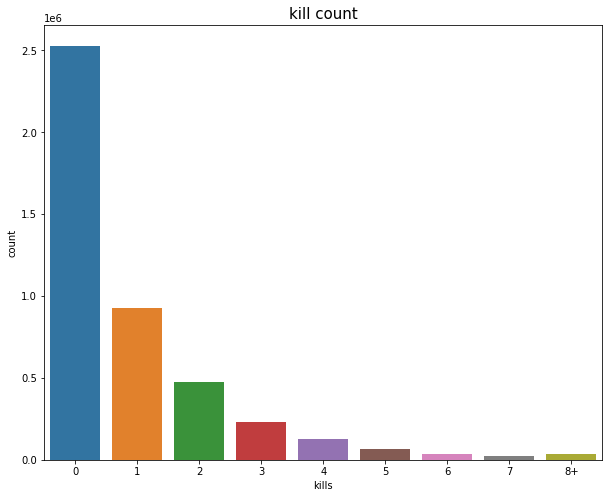

In [ ]:
#number of each count of kills recorded
data=raw1_df.copy()
data.loc[data['kills']>data['kills'].quantile(0.99)]='8+'
sns.countplot(x=data['kills'].astype('str').sort_values())
plt.title("kill count",fontsize=15)
plt.show();

From the above graph we can see the number of registered kills steadly decreeases as the number of kills increases from zero.

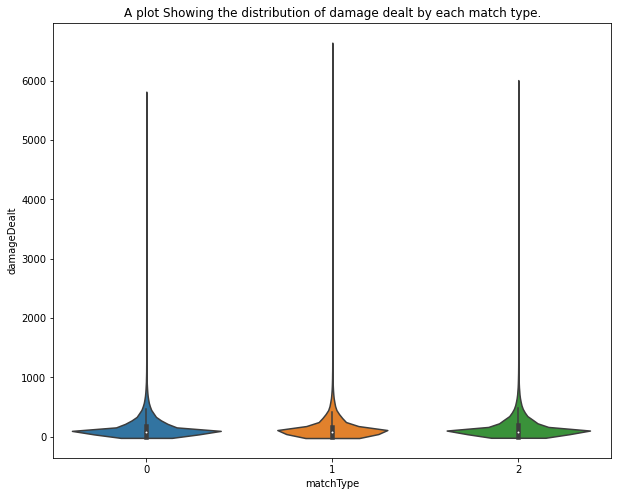

In [ ]:
sns.violinplot(data= raw1_df, x="matchType", y="damageDealt").set(title="A plot Showing the distribution of damage dealt by each match type.");

From the above bins we can note that damageDealt below 1000 is more common than damageDealt above 1000. Also, solo team play deals the most damage.

### Outlier cases

In [ ]:
print("{} players ({:.3f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]),
                                                                    100*len(data[data['winPlacePerc']==1])/len(raw1_df)))
data1=raw1_df[raw1_df['damageDealt']==0].copy()
print("{} players ({:.3f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]),
                                                                     100*len(data1[data1['winPlacePerc']==1])/len(raw1_df)))

114089 players (2.566%) have won without a single kill!
4770 players (0.107%) have won without dealing damage!


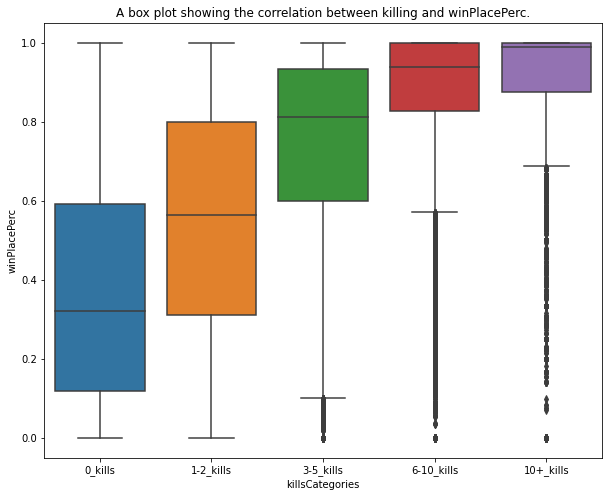

In [ ]:
#Plotting correlation between killing and winning PUBG
kills= raw1_df.copy()
kills['killsCategories']= pd.cut(kills['kills'],[-1,0,2,5,10,60],labels=['0_kills','1-2_kills','3-5_kills','6-10_kills','10+_kills'])
sns.boxplot(x='killsCategories',y="winPlacePerc",data=kills).set(title="A box plot showing the correlation between killing and winPlacePerc.")
plt.show();

From the bins in the graph we can see that the mean value ie winPlacePerc increases with increase in number of kills. Also the interquatile range and quatile group 4 range of the bins reduces with increase in number of kills. Plus from the 3-5 kills bin there is a significant increase in the number of outliners below the minimum as the number of kills increases.

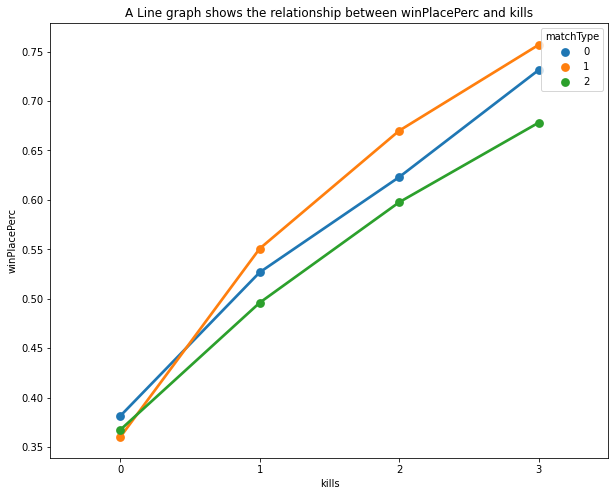

In [ ]:
gp_kills = raw1_df[raw1_df['kills'] <= raw1_df['kills'].quantile(.9)]
sns.pointplot(data=gp_kills, x='kills',y='winPlacePerc', hue='matchType').set(title='A Line graph shows the relationship between winPlacePerc and kills');

From the above graph we can say that as the number of kills increases chances of winning increases but it this effect is more helpful for solo players (1) than duo (0) or squad (2) players.

In [ ]:
print("average person uses {:.1f}m heal items, 99% people uses {}m or less, while the doctor used {}m. "
.format(raw1_df['heals'].mean(),raw1_df['heals'].quantile(0.99),raw1_df['heals'].max()))
print("average person uses {:.1f}m boost items, 99% people uses {}m or less, while the doctor used {}m. "
.format(raw1_df['boosts'].mean(),raw1_df['boosts'].quantile(0.99), raw1_df['boosts'].max()))

average person uses 1.4m heal items, 99% people uses 12.0m or less, while the doctor used 80m. 
average person uses 1.1m boost items, 99% people uses 7.0m or less, while the doctor used 33m. 


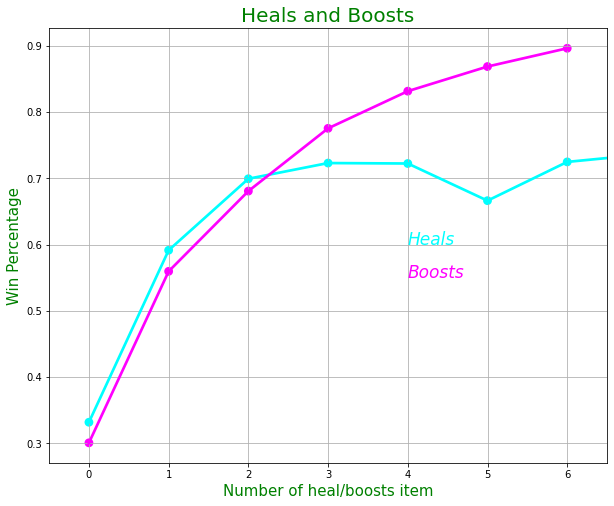

In [ ]:
#relationship between winPlacePerc and Heals/Boots');
data_md= raw1_df.copy()
data_md= data_md[data_md['heals']<data_md['heals'].quantile(0.99)]
data_md= data_md[data_md['boosts']<data_md['boosts'].quantile(0.99)]
sns.pointplot(data=data_md, x='heals',y='winPlacePerc', color='cyan')
sns.pointplot(data=data_md, x='boosts',y='winPlacePerc', color='magenta')
plt.text(4,0.6,'Heals',color='cyan',fontsize=17,style='italic')
plt.text(4,0.55,'Boosts',color='magenta',fontsize=17,style='italic')
plt.xlabel('Number of heal/boosts item',fontsize=15,color='green')
plt.ylabel('Win Percentage',fontsize=15,color='g')
plt.title('Heals and Boosts',fontsize=20,color='g')
plt.grid()
plt.show()

* So healing and boosting are coorelated with winPlacePerc.
* Boosting is more.
* In every plot there is an abnormal behaviour when values are 0.
* Person correlation with the variables

### Anomalies
While Analyzing the dataset we found some irregularities in the data, so handling those anomalies now

1) Have done kills but have not travel any distance

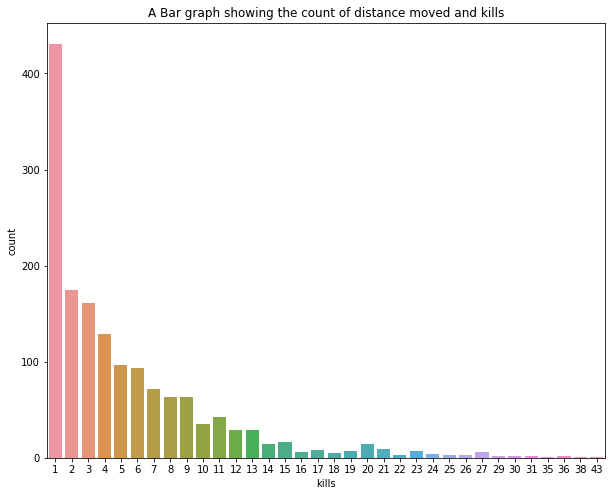

In [ ]:
sns.countplot(data= raw1_df[(raw1_df['walkDistance'] + raw1_df['rideDistance'] + raw1_df['swimDistance']==0) & (raw1_df['kills'] > 0)],
              x='kills').set(title='A Bar graph showing the count of distance moved and kills');

So the above graph is of the players who travel zero distance yet they have killed enemies seems suspicious, hence removing those rows!!

In [ ]:
raw1_df.drop(raw1_df[(raw1_df['walkDistance'] + raw1_df['rideDistance'] + raw1_df['swimDistance']==0) & (raw1_df['kills'] > 0)].index, axis=0, inplace = True)

2 Longest kill is zero but kills aint zero

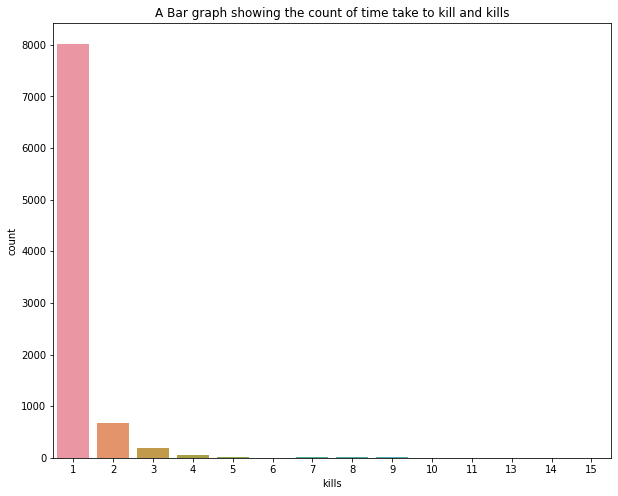

In [ ]:
sns.countplot(data=raw1_df[(raw1_df['longestKill']==0) & (raw1_df['kills'] > 0)], x='kills').set(title='A Bar graph showing the count of time take to kill and kills');

The graph is of kills where the longest kill is zero

In [ ]:
index_drop = raw1_df[(raw1_df['longestKill']==0) & (raw1_df['kills'] > 0)].index
raw1_df.drop(index_drop,axis= 0,inplace= True)

3 Team-player killers without weapon or drove a car/vehicle


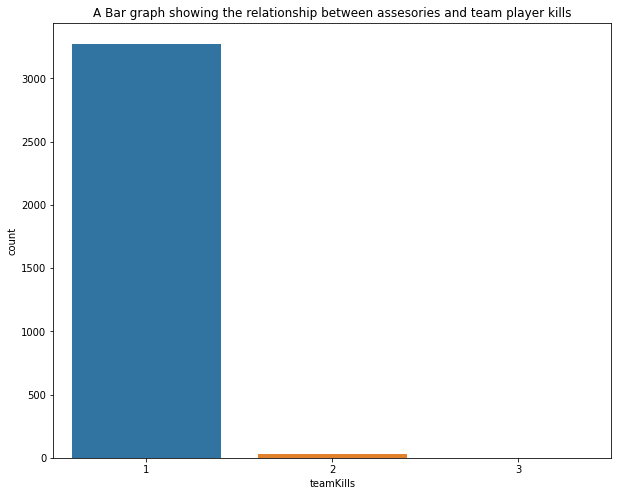

In [ ]:
sns.countplot(data=raw1_df[(raw1_df['weaponsAcquired']==0) & (raw1_df['teamKills']>0) & (raw1_df['rideDistance']==0)], x='teamKills').set(title='A Bar graph showing the relationship between assesories and team player kills');

 In pubg, a player can kill his/her team-mate only if he has grenade(weapon) or he/she has drove a vehicle over his/her team-mate. But from the above condition graph there are some players who have killed teamplayer yet they have not acquire any weapon or drove a car/vehicle.


In [ ]:
index_drop = raw1_df[(raw1_df['weaponsAcquired']==0) & (raw1_df['teamKills']>0) & (raw1_df['rideDistance']==0)].index
raw1_df.drop(index_drop, axis=0, inplace = True)
print(len(index_drop), " rows dropped!!")

3303  rows dropped!!


4 Killing players from the car but have not ride the car probably illegal data

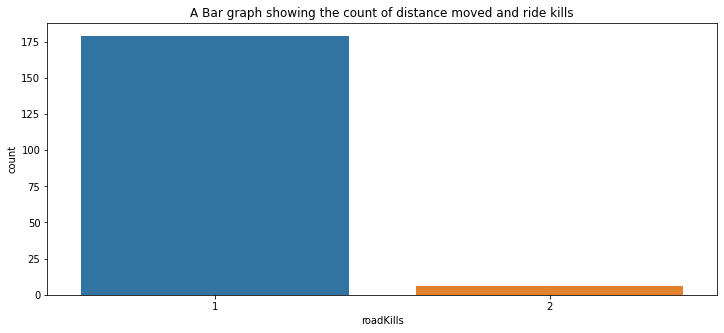

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(data=raw1_df[(raw1_df['roadKills']>0) & (raw1_df['rideDistance']==0)], x='roadKills').set(title='A Bar graph showing the count of distance moved and ride kills');

The graph is of players with roadkills bt have not cars

In [ ]:
index_drop = raw1_df[(raw1_df['roadKills']>0) & (raw1_df['rideDistance']==0)].index
print(index_drop.shape)
raw1_df.drop(index_drop, axis=0, inplace = True)

(185,)


5) Have not walked but have consumed heals and boost, its not possible

In [ ]:
index_drop = raw1_df[((raw1_df['heals']>0) | (raw1_df['boosts']>0)) & (raw1_df['walkDistance']==0)].index
print(index_drop.shape)
raw1_df.drop(index_drop, axis=0, inplace = True)

(450,)


6) Its not possible to acquire weapon if a player has not walked a distamce

In [ ]:
index_drop = raw1_df[(raw1_df['weaponsAcquired']>0) & (raw1_df['walkDistance']==0)].index
print(index_drop.shape)
raw1_df.drop(index_drop, axis=0, inplace = True)

(17012,)


7) If matchType is solo then there cannot be any assists value, because to assist we need teammate which we don't have, here as the number are somewhat high, so instead of dropping the rows, we imputed that feature with 0.

In [ ]:
index_replace = raw1_df[(raw1_df['matchType']==1) & (raw1_df['assists']>0)].index
print(index_replace.shape)
raw1_df.loc[index_replace,'assists'] = 0

(39662,)


8) A player cannot assist a teammate if the walkDistance is 0

In [ ]:
index_drop = raw1_df[(raw1_df['assists']>0) & (raw1_df['walkDistance']==0)].index
print(index_drop.shape)
raw1_df.drop(index_drop, axis=0, inplace = True)

(73,)


9) A player cannot dealt damage if he has not walked a single meter

In [ ]:
index_drop = raw1_df[(raw1_df['damageDealt']>0) & (raw1_df['walkDistance']==0)].index
print(index_drop.shape)
raw1_df.drop(index_drop, axis=0, inplace = True)

(1702,)


## Preprocessing

### Correlation Matrix

<ipython-input-52-ef931eaaa09b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(raw1_df.corr(), annot=True);


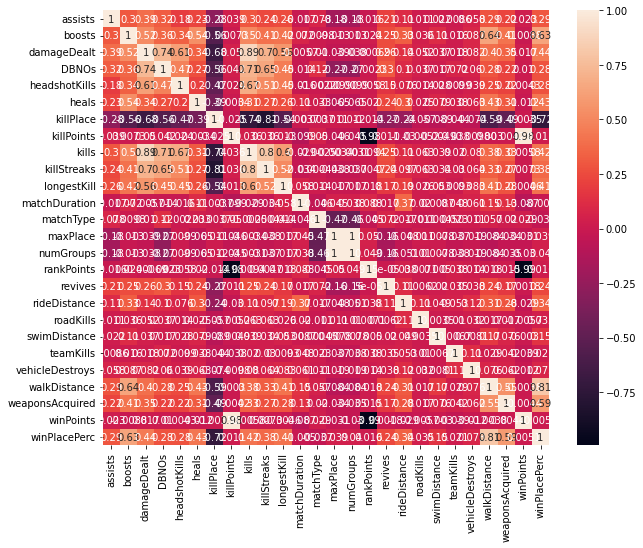

In [ ]:
sns.heatmap(raw1_df.corr(), annot=True);

In [ ]:
def getCorrelatedFeatures(corrdata, threshold):
    key_features = []
    key_value = []
    for i,index in enumerate(corrdata.index):
        if abs(corrdata[index])>threshold:
            key_features.append(index)
            key_value.append(corrdata[index])

    df = pd.DataFrame(data = key_value, index = key_features,columns = ['CorrValue'] )
    return df,key_features

In [ ]:
threshold = 0.4
corr_value,train_features = getCorrelatedFeatures(raw1_df.corr()['winPlacePerc'],threshold)
print(corr_value)

<ipython-input-54-674d339c3eca>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_value,train_features = getCorrelatedFeatures(raw1_df.corr()['winPlacePerc'],threshold)


                 CorrValue
boosts            0.634557
damageDealt       0.441151
heals             0.427561
killPlace        -0.722118
kills             0.420085
longestKill       0.410535
walkDistance      0.811238
weaponsAcquired   0.587883
winPlacePerc      1.000000


### Feature Engineering
Based on the CorrValue we are going to combine columns in our database to generate relevant data

In [ ]:
features = ['kills', 'killsPerc',
            'killPlace', 'killPlacePerc',
            'walkDistance', 'walkDistancePerc',
            'killPlace_maxPlace_Ratio',
            'killsPerc_walkDistancePerc_Ratio',
            'killPlacePerc_walkDistancePerc_Ratio',
            ]

In [ ]:
def featureEngineering_point(df):
  df.loc[(df['rankPoints'] < 0), 'rankPoints'] = 0
  df.loc[(df['killPoints'] < 0), 'killPoints'] = 0

  df['points'] = df['rankPoints'] + df['killPoints']

  df['pointsPerc'] = df.groupby('matchId')['points'].rank(pct=True)

  return df


def featureEngineering_teamplay(df):
  df['DBNOsPerc'] = df.groupby('matchId')['DBNOs'].rank(pct=True)

  return df


def featureEngineering_kill(df):
  df['killsPerc'] = df.groupby('matchId')['kills'].rank(pct=True)
  df['longestKillPerc'] = df.groupby('matchId')['longestKill'].rank(pct=True)
  df['killPlacePerc'] = df.groupby('matchId')[['killPlace']].rank(pct=True)

  df['killStreaksPerKill'] = df['killStreaks'] / df['kills']
  df['headShotPerKill'] = df['headshotKills'] / df['kills']
  df['damageDealtPerKill'] = df['damageDealt'] / df['kills']
  df['matchDurationPerKill'] = df['matchDuration'] / df['kills']

  df['killPlace_maxPlace_Ratio'] = df['killPlace'] / df['maxPlace']

  return df


def featureEngineering_distance(df):
  df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']

  df['walkDistancePerc'] = df.groupby('matchId')['walkDistance'].rank(pct=True)
  df['totalDistancePerc'] = df.groupby('matchId')['totalDistance'].rank(pct=True)

  df['totalDistancePerDuration'] = df['totalDistance'] / df['matchDuration']
  df['walkDistancePerDuration'] = df['walkDistance'] / df['matchDuration']
  df['walkDistancePerKill'] = df['walkDistance'] / df['kills']
  df['totalDistancePerKill'] = df['totalDistance'] / df['kills']
  df['totalDistancePerHeal'] = df['totalDistance'] / df['heals']

  df['killsPerc_walkDistancePerc_Ratio'] = df['killsPerc'] / df['walkDistancePerc']
  df['killsPerc_totalDistancePerc_Ratio'] = df['killsPerc'] / df['totalDistancePerc']
  df['killPlacePerc_walkDistancePerc_Ratio'] = df['killPlacePerc'] / df['walkDistancePerc']
  df['killPlacePerc_totalDistancePerc_Ratio'] = df['killPlacePerc'] / df['totalDistancePerc']

  return df


def featureEngineering_item(df):
  df['items'] = df['boosts'] + df['heals']

  df['itemsPerc'] = df.groupby('matchId')['items'].rank(pct=True)
  df['weaponsAcquiredPerc'] = df.groupby('matchId')['weaponsAcquired'].rank(pct=True)

  df['totalDistancePerItem'] = df['totalDistance'] / df['items']
  df['totalDistancePerWeapon'] = df['totalDistance'] / df['weaponsAcquired']

  return df


def featureEngineering_inf(df):
  df[df == np.Inf] = np.NaN
  df[df == np.NINF] = np.NaN
  df.fillna(0, inplace=True)

  return df


def featureEngineering_groupby_groupId(df, fn):
  df_group = df.groupby(['matchId', 'groupId'])[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_group_{fn}'], how='left', on=['matchId', 'groupId'])

  df_group_rank = df_group.groupby('matchId')[features].rank(pct=True)
  df = pd.merge(df, df_group_rank, suffixes=['', f'_group_{fn}_rank'], how='left', on=['matchId', 'groupId'])

  del df_group
  del df_group_rank
  gc.collect()

  return df


def featureEngineering_group_size(df):
  df_group = df.groupby(['matchId', 'groupId']).size().reset_index(name='groupSize')
  df = pd.merge(df, df_group, how='left', on=['matchId', 'groupId'])

  del df_group
  gc.collect()

  return df


def featureEngineering_groupby_matchId(df, fn):
  df_group = df.groupby(['matchId'])[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_match_{fn}'], how='left', on=['matchId'])

  del df_group
  gc.collect()

  return df


def featureEngineering_match_size(df):
  df_group = df.groupby(['matchId']).size().reset_index(name='matchSize')
  df = pd.merge(df, df_group, how='left', on=['matchId'])

  del df_group
  gc.collect()

  return df

def get_FeatureEngineering(df):
  df = featureEngineering_point(df)
  df = featureEngineering_teamplay(df)
  df = featureEngineering_kill(df)
  df = featureEngineering_distance(df)
  df = featureEngineering_item(df)
  df = featureEngineering_inf(df)
  df = reduce_mem_usage(df)

  df = featureEngineering_groupby_groupId(df, 'mean')
  df = featureEngineering_groupby_groupId(df, 'min')
  df = featureEngineering_groupby_groupId(df, 'max')
  df = featureEngineering_group_size(df)
  df = reduce_mem_usage(df)

  df = featureEngineering_groupby_matchId(df, 'mean')
  df = featureEngineering_groupby_matchId(df, 'min')
  df = featureEngineering_groupby_matchId(df, 'max')
  df = featureEngineering_match_size(df)
  df = reduce_mem_usage(df)

  return df

In [ ]:
get_FeatureEngineering(raw1_df)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,kills_match_max,killsPerc_match_max,killPlace_match_max,killPlacePerc_match_max,walkDistance_match_max,walkDistancePerc_match_max,killPlace_maxPlace_Ratio_match_max,killsPerc_walkDistancePerc_Ratio_match_max,killPlacePerc_walkDistancePerc_Ratio_match_max,matchSize
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,7,1.000000,96,1.0,4460.0,1.0,3.428571,19.333334,63.333332,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,7,1.000000,90,1.0,5956.0,1.0,3.461539,22.500000,88.000000,90
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,9,1.000000,98,1.0,4801.0,1.0,1.960000,9.500000,32.000000,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,7,1.000000,91,1.0,3490.0,1.0,2.935484,25.000000,86.000000,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,11,1.000000,97,1.0,3188.0,1.0,1.000000,16.125000,48.000000,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4413707,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.000000,0,0,0,74,...,8,0.994565,94,1.0,4355.0,1.0,3.241379,27.000000,87.000000,92
4413708,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.150002,0,0,0,69,...,8,1.000000,93,1.0,3348.0,1.0,1.000000,27.000000,92.000000,92
4413709,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.060001,0,0,0,66,...,8,1.000000,98,1.0,3241.0,1.0,3.500000,29.000000,98.000000,98
4413710,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.399994,1,1,2,11,...,25,1.000000,94,1.0,3276.0,1.0,3.615385,30.500000,84.000000,93


In [ ]:
get_FeatureEngineering(test1_df)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,kills_match_max,killsPerc_match_max,killPlace_match_max,killPlacePerc_match_max,walkDistance_match_max,walkDistancePerc_match_max,killPlace_maxPlace_Ratio_match_max,killsPerc_walkDistancePerc_Ratio_match_max,killPlacePerc_walkDistancePerc_Ratio_match_max,matchSize
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.459999,0,0,0,73,...,7,1.000000,92,1.0,5338.0,1.0,3.285714,28.500000,85.000000,92
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.100006,0,0,2,11,...,10,1.000000,96,1.0,4210.0,1.0,2.000000,28.500000,92.000000,96
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.400000,0,0,4,49,...,8,1.000000,94,1.0,3786.0,1.0,3.357143,17.333334,60.666668,94
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.519997,0,0,0,54,...,10,1.000000,89,1.0,5075.0,1.0,1.977778,27.333334,58.000000,89
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.200012,1,2,1,7,...,7,1.000000,95,1.0,3067.0,1.0,3.392857,25.500000,92.000000,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.000000,3,0,7,4,...,6,1.000000,76,1.0,2992.0,1.0,3.454545,9.400000,26.799999,76
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.000000,0,0,0,64,...,7,1.000000,92,1.0,4066.0,1.0,3.407408,7.714286,25.714285,92
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.959999,0,0,3,24,...,7,1.000000,94,1.0,3607.0,1.0,3.241379,9.333333,30.666666,94
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.600006,0,0,12,25,...,6,0.984375,96,1.0,3872.0,1.0,1.959184,27.500000,94.000000,96


In [ ]:
raw1_df.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)
test1_df.drop(['Id', 'groupId', 'matchId'], axis=1, inplace=True)

In [ ]:
winPlace_corr1 = pd.DataFrame(raw1_df.corr()['winPlacePerc'])
winPlace_corr1

,winPlacePerc
assists,0.293589
boosts,0.634557
damageDealt,0.441151
DBNOs,0.279085
headshotKills,0.277460
heals,0.427561
killPlace,-0.722118
killPoints,0.011152
kills,0.420085
killStreaks,0.375661


### Identifying Input and Target Columns

In [ ]:
# Generating a sample dataframe for model tuning
raw2_df = raw1_df.sample(frac=0.2)

In [ ]:
#preparing variable from which the train and target set will be generated from
targets = raw1_df.winPlacePerc
inputs = raw1_df[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals','killPlace', 'killPoints',
                  'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'numGroups',
                  'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
                  'walkDistance', 'weaponsAcquired', 'winPoints', 'points', 'pointsPerc', 'DBNOsPerc', 'killsPerc',
                  'longestKillPerc', 'killPlacePerc', 'killStreaksPerKill', 'headShotPerKill', 'damageDealtPerKill',
                  'matchDurationPerKill', 'killPlace_maxPlace_Ratio', 'totalDistance', 'walkDistancePerc', 'totalDistancePerc',
                  'totalDistancePerDuration', 'walkDistancePerDuration', 'walkDistancePerKill', 'totalDistancePerKill',
                  'totalDistancePerHeal', 'killsPerc_walkDistancePerc_Ratio', 'killsPerc_totalDistancePerc_Ratio',
                  'killPlacePerc_walkDistancePerc_Ratio', 'killPlacePerc_totalDistancePerc_Ratio', 'items', 'itemsPerc',
                  'weaponsAcquiredPerc', 'totalDistancePerItem', 'totalDistancePerWeapon'
                  ]]

In [ ]:
targets1 = raw2_df.winPlacePerc
inputs1 = raw2_df[['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals','killPlace', 'killPoints',
                  'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace', 'numGroups',
                  'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
                  'walkDistance', 'weaponsAcquired', 'winPoints', 'points', 'pointsPerc', 'DBNOsPerc', 'killsPerc',
                  'longestKillPerc', 'killPlacePerc', 'killStreaksPerKill', 'headShotPerKill', 'damageDealtPerKill',
                  'matchDurationPerKill', 'killPlace_maxPlace_Ratio', 'totalDistance', 'walkDistancePerc', 'totalDistancePerc',
                  'totalDistancePerDuration', 'walkDistancePerDuration', 'walkDistancePerKill', 'totalDistancePerKill',
                  'totalDistancePerHeal', 'killsPerc_walkDistancePerc_Ratio', 'killsPerc_totalDistancePerc_Ratio',
                  'killPlacePerc_walkDistancePerc_Ratio', 'killPlacePerc_totalDistancePerc_Ratio', 'items', 'itemsPerc',
                  'weaponsAcquiredPerc', 'totalDistancePerItem', 'totalDistancePerWeapon'
                  ]]

### Scaling

In [ ]:
#reducing the range of our values so that the max is 1 and min 0 using MinMaxScaler,
scaler = MinMaxScaler()

In [ ]:
scaler.fit(inputs)

MinMaxScaler()

In [ ]:
inputs = scaler.transform(inputs)
inputs1 = scaler.transform(inputs1)
test1_df = scaler.transform(test1_df)

### Spliting the Machine Learning Data

In [ ]:
#creating a train and validation set train_test_split
train_inputs, val_inputs, train_target, val_target= train_test_split(inputs, targets,test_size=0.3,random_state=42)

In [ ]:
#creating a train and validation set from the sample data for hyperparameter tunning
train_inputs1, val_inputs1, train_target1, val_target1= train_test_split(inputs1, targets1,test_size=0.3,random_state=42)

In [ ]:
print('train_inputs shape-',train_inputs.shape, '\n','val_inputs shape-',val_inputs.shape)

train_inputs shape- (3089598, 53) 
 val_inputs shape- (1324114, 53)


In [ ]:
print('train_target shape-',train_target.shape,'\n','val_target shape-',val_target.shape)

train_target shape- (3089598,) 
 val_target shape- (1324114,)


In [ ]:
print('sample_train_inputs shape-',train_inputs1.shape, '\n','sample_val_inputs shape-',val_inputs1.shape)

sample_train_inputs shape- (617919, 53) 
 sample_val_inputs shape- (264823, 53)


In [ ]:
print('sample_train_target shape-',train_target1.shape,'\n','sample_val_target shape-',val_target1.shape)

sample_train_target shape- (617919,) 
 sample_val_target shape- (264823,)


## Model

### Model tuning
The best two regressors for our data are CatBoostRegressor and LGBMRegressor. We will use GridSearchCV to tune the hyperparameters to get the best performance from our models.

### Tunning CatBoostRegressor model

In [ ]:
#Finding the best hyperparameters for the random forest model
#listing the hyperparameters to test in our GridSearchCv search space
rgs_cb = GridSearchCV(CatBoostRegressor (random_state=42, loss_function='RMSE', verbose=False, thread_count=-1),{
    'depth':np.arange(4,10,2),
    'random_strength':np.arange(0,10,4),
    'l2_leaf_reg': np.arange(2,15,5),
    }, cv=5, return_train_score=False,
)

In [ ]:
#Using sample data to reduce run time
rgs_cb.fit(train_inputs1, train_target1)

In [ ]:
#storing the results in a dataframe
rgs_cb_results = pd.DataFrame(rgs_cb.cv_results_)

In [ ]:
rgs_cb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_l2_leaf_reg,param_random_strength,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.313885,0.478066,0.152776,0.011019,4,2,0,"{'depth': 4, 'l2_leaf_reg': 2, 'random_strengt...",0.946686,0.948462,0.948282,0.947990,0.947072,0.947698,0.000696,19
1,11.918347,0.038820,0.142815,0.006466,4,2,4,"{'depth': 4, 'l2_leaf_reg': 2, 'random_strengt...",0.946438,0.948203,0.947760,0.947518,0.946635,0.947311,0.000672,22
2,12.078221,0.094202,0.142712,0.006063,4,2,8,"{'depth': 4, 'l2_leaf_reg': 2, 'random_strengt...",0.945890,0.947718,0.947380,0.947100,0.946022,0.946822,0.000735,25
3,11.949414,0.060499,0.146141,0.005776,4,7,0,"{'depth': 4, 'l2_leaf_reg': 7, 'random_strengt...",0.946747,0.948515,0.948239,0.947904,0.947017,0.947684,0.000688,20
4,11.853045,0.070452,0.151170,0.010723,4,7,4,"{'depth': 4, 'l2_leaf_reg': 7, 'random_strengt...",0.946203,0.948145,0.947688,0.947453,0.946496,0.947197,0.000733,23
5,11.928516,0.063893,0.145228,0.006285,4,7,8,"{'depth': 4, 'l2_leaf_reg': 7, 'random_strengt...",0.945786,0.947765,0.947382,0.946751,0.946054,0.946748,0.000754,26
6,11.828104,0.072562,0.140496,0.005025,4,12,0,"{'depth': 4, 'l2_leaf_reg': 12, 'random_streng...",0.946672,0.948465,0.948176,0.947877,0.947018,0.947642,0.000685,21
7,11.926306,0.130154,0.143785,0.006334,4,12,4,"{'depth': 4, 'l2_leaf_reg': 12, 'random_streng...",0.946236,0.948096,0.947785,0.947248,0.946445,0.947162,0.000727,24
8,11.870541,0.038281,0.153327,0.007174,4,12,8,"{'depth': 4, 'l2_leaf_reg': 12, 'random_streng...",0.945821,0.947656,0.947231,0.946894,0.945968,0.946714,0.000713,27
9,15.619135,0.265655,0.154745,0.005070,6,2,0,"{'depth': 6, 'l2_leaf_reg': 2, 'random_strengt...",0.951688,0.953209,0.952820,0.952888,0.951829,0.952487,0.000611,10


In [ ]:
print('best score:',rgs_cb.best_score_,'\n', 'best parameters:',rgs_cb.best_params_)

In [ ]:
model_cb1 = CatBoostRegressor(random_state=42,
                              depth=9,
                              iterations=1000,
                              learning_rate=0.1,
                              loss_function='RMSE',
                              bagging_freq= 0,
                              l2_leaf_reg= 2,
                              leaf_estimation_iterations= 2
                              )
model_cb1.fit(train_inputs, train_target)
val_preds_cb1 = model_cb1.predict(val_inputs)

0:	learn: 0.2802927	total: 155ms	remaining: 2m 34s
1:	learn: 0.2566304	total: 298ms	remaining: 2m 28s
2:	learn: 0.2353794	total: 430ms	remaining: 2m 22s
3:	learn: 0.2165815	total: 568ms	remaining: 2m 21s
4:	learn: 0.1999237	total: 704ms	remaining: 2m 20s
5:	learn: 0.1850849	total: 840ms	remaining: 2m 19s
6:	learn: 0.1720162	total: 986ms	remaining: 2m 19s
7:	learn: 0.1603765	total: 1.13s	remaining: 2m 19s
8:	learn: 0.1502275	total: 1.27s	remaining: 2m 19s
9:	learn: 0.1414261	total: 1.41s	remaining: 2m 19s
10:	learn: 0.1337819	total: 1.54s	remaining: 2m 18s
11:	learn: 0.1268028	total: 1.68s	remaining: 2m 18s
12:	learn: 0.1208650	total: 1.82s	remaining: 2m 18s
13:	learn: 0.1154255	total: 1.95s	remaining: 2m 17s
14:	learn: 0.1109657	total: 2.08s	remaining: 2m 16s
15:	learn: 0.1071097	total: 2.22s	remaining: 2m 16s
16:	learn: 0.1037739	total: 2.35s	remaining: 2m 15s
17:	learn: 0.1008526	total: 2.47s	remaining: 2m 14s
18:	learn: 0.0983200	total: 2.6s	remaining: 2m 14s
19:	learn: 0.0962128	to

In [ ]:
print("Mean_squared_error : ", mean_squared_error(val_target, val_preds_cb2) *  100)

Mean_squared_error :  0.4004876443018084


In [ ]:
print("Mean_squared_error : ", mean_squared_error(val_target, val_preds_cb1) *  100)

Mean_squared_error :  0.4004876443018084


### Predicting winPlacPerc using CatBoostRegressor model
Submitting a csv using the CatBoostRegressor model from the test data

In [ ]:
submission_cb_df = test_df[['Id']]

In [ ]:
submission_cb_df['winPlacePerc'] = model_cb1.predict(test1_df)

In [ ]:
submission_cb_df

,Id,winPlacePerc
0,9329eb41e215eb,0.205669
1,639bd0dcd7bda8,0.893708
2,63d5c8ef8dfe91,0.777409
3,cf5b81422591d1,0.487336
4,ee6a295187ba21,0.900731
...,...,...
1934169,a316c3a13887d5,0.741127
1934170,5312146b27d875,0.363713
1934171,fc8818b5b32ad3,0.879141
1934172,a0f91e35f8458f,0.848397


In [ ]:
submission_cb_df.to_csv('submission_cb.csv', index=False)

### Tunning LGBMRegressorRegressor model

In [ ]:
rgs_lb = GridSearchCV(LGBMRegressor(random_state=42, n_jobs=-1),{
    'max_depth':[15,40,60,100],
    'min_data_in_leaf': [10,50,100,150,200],
    'bagging_freq': [0,2,5,10],
    }, cv=5, return_train_score=False
)

In [ ]:
#Using sample data to reduce run time
rgs_lb.fit(train_inputs1, train_target1)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42),
             param_grid={'bagging_freq': [0, 2, 5, 10],
                         'max_depth': [15, 40, 60, 100],
                         'min_data_in_leaf': [10, 50, 100, 150, 200]})

In [ ]:
#storing the results in a dataframe
rgs_lb_results = pd.DataFrame(rgs_lb.cv_results_)

In [ ]:
rgs_lb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_freq,param_max_depth,param_min_data_in_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.255717,7.457127,0.051403,0.011685,0,15,10,"{'bagging_freq': 0, 'max_depth': 15, 'min_data...",0.950000,0.951054,0.950945,0.950756,0.949560,0.950463,0.000583,17
1,2.821196,0.723581,0.047612,0.005055,0,15,50,"{'bagging_freq': 0, 'max_depth': 15, 'min_data...",0.950038,0.951128,0.950885,0.950786,0.949547,0.950477,0.000591,13
2,2.664376,0.346228,0.047511,0.003834,0,15,100,"{'bagging_freq': 0, 'max_depth': 15, 'min_data...",0.950055,0.951068,0.950958,0.950691,0.949383,0.950431,0.000631,45
3,3.101884,0.608382,0.045529,0.000891,0,15,150,"{'bagging_freq': 0, 'max_depth': 15, 'min_data...",0.949731,0.951077,0.950924,0.950752,0.949468,0.950390,0.000659,73
4,3.295399,1.195305,0.047717,0.003487,0,15,200,"{'bagging_freq': 0, 'max_depth': 15, 'min_data...",0.949670,0.951133,0.950815,0.950727,0.949509,0.950371,0.000654,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,3.098968,0.857410,0.044668,0.000348,10,100,10,"{'bagging_freq': 10, 'max_depth': 100, 'min_da...",0.949952,0.951103,0.950848,0.950777,0.949609,0.950458,0.000574,21
76,2.818235,0.649122,0.048868,0.008730,10,100,50,"{'bagging_freq': 10, 'max_depth': 100, 'min_da...",0.950049,0.951075,0.951041,0.950818,0.949559,0.950508,0.000602,1
77,2.771303,0.335767,0.046659,0.004570,10,100,100,"{'bagging_freq': 10, 'max_depth': 100, 'min_da...",0.949806,0.951201,0.950875,0.950758,0.949324,0.950393,0.000708,61
78,3.234504,1.041176,0.045819,0.001418,10,100,150,"{'bagging_freq': 10, 'max_depth': 100, 'min_da...",0.949886,0.951187,0.950902,0.950807,0.949454,0.950447,0.000661,33


In [ ]:
print('best score:',rgs_lb.best_score_,'\n', 'best parameters:',rgs_lb.best_params_)

best score: 0.950508398746767 
 best parameters: {'bagging_freq': 0, 'max_depth': 40, 'min_data_in_leaf': 50}


In [ ]:
model_lb1 = LGBMRegressor(random_state=42,
                         n_estimators=1000,
                         num_leaves=63,
                         learning_rate=0.1,
                         max_depth = 50,
                         bagging_freq= 0,
                         min_data_in_leaf = 50,
                         n_jobs=-1
                          )
model_lb1.fit(train_inputs, train_target)
val_preds_lb1 = model_lb1.predict(val_inputs)

In [ ]:
print("Mean_squared_error : ", mean_squared_error(val_target, val_preds_lb1) *  100)

Mean_squared_error :  0.39988619088044997


### Predicting winPlacPerc using LGBMRegressorRegressor model
Submitting a csv using the LGBMRegressor model from the test data

In [ ]:
submission_lb_df = test_df[['Id']]

In [ ]:
submission_lb_df['winPlacePerc'] = model_lb1.predict(test1_df)

In [ ]:
submission_lb_df

,Id,winPlacePerc
0,9329eb41e215eb,0.203982
1,639bd0dcd7bda8,0.899805
2,63d5c8ef8dfe91,0.760090
3,cf5b81422591d1,0.480914
4,ee6a295187ba21,0.899680
...,...,...
1934169,a316c3a13887d5,0.789475
1934170,5312146b27d875,0.366422
1934171,fc8818b5b32ad3,0.882753
1934172,a0f91e35f8458f,0.852412


In [ ]:
submission_lb_df.to_csv('submission_lb.csv', index=False)

## Summary
[![submission](https://i.imgur.com/wrOxh7V.jpg)](https://www.kaggle.com/competitions/pubg-finish-placement-prediction/submissions)




Using insights from our EDA and feature engineering we were able to reduced the mean squared error from 0.68 to 0.045. from our test data the our LGBM model performed better than the CatBoost model with a MSE score of 0.39988619088044997 and 0.4004876443018084 respectively. But from our submissions results the CatBoost model performs better than the LGBM with a score of 0.04523 and 0.04525.


That's why both models were submitted.

## Future Works
*  Find out why there is a difference in the model's performance position when used on test data and when submitted
*  We have seen the impotrtance of feature engineering and hyperaparameter tunning. So, in order to reduce the MSE further we need to investigate using EDA with the target of a submission score of <= 0.01385.

## References
* [PUBG Finish Placement Prediction (Kernels Only)](https://www.kaggle.com/competitions/pubg-finish-placement-prediction 'Click for more info.')
* [1st Place Solution](https://www.kaggle.com/competitions/pubg-finish-placement-prediction/discussion/79161 'Click for more info.')
* [kaggle notebook](https://www.kaggle.com/code/esxmod/notebookac21ee6192 'Click for more info.')
* [lightgbm..LGBMRegressor documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html 'Click for more info.')
* [CatBoostRegressor documentation](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor 'Click for more info.')
* [Faster CatBoost Training](https://towardsdatascience.com/10x-times-fast-catboost-training-speed-with-an-nvidia-gpu-5ffefd9b57a6#:~:text=Also%2C%20in%20my%20“5%20Cute,both%20CPU%20and%20GPU%20training. 'Click for more info.')
* [LightGBM Hyperparameter Tuning](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5#:~:text=In%20LGBM%2C%20the%20most%20important,The%20next%20is%20max_depth%20. 'Click for more info.')
* [Tune a CatBoost model](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html 'Click for more info.')
* [Tune a LightGBM model](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-tuning.html 'Click for more info.')